# 第6章 LangGraph 开发基础

## 💡 学习目标

1. 掌握 LangGraph 的核心概念和使用场景
2. 掌握 LangGraph 的基本用法

## 1. LangGraph 介绍

### 1.1 基本概述

LangGraph 是由 LangChain 团队开发的一个开源框架，旨在帮助开发者构建基于大型语言模型（LLM）的复杂、有状态、多主体的应用。它通过将工作流表示为图结构（graph），提供了更高的灵活性和控制能力，特别适合需要循环逻辑、状态管理以及多主体协作的场景，比如智能代理（agent）和多代理工作流。

LangGraph 是为智能体和工作流设计一套底层编排框架

官方文档：https://langchain-ai.github.io/langgraph/

### 1.2 核心概念

**图结构（Graph Structure）**

LangGraph 将应用逻辑组织成一个有向图，其中：

- 节点（Nodes）：代表具体的操作或计算步骤，可以是调用语言模型、执行函数或与外部工具交互等
- 边（Edges）：定义节点之间的连接和执行顺序，支持普通边（直接连接）和条件边（基于条件动态选择下一步）

**状态管理（State Management）**

LangGraph 的核心特点是自动维护和管理状态

状态（State）是一个贯穿整个图的共享数据结构，记录了应用运行过程中的上下文信息

每个节点可以根据当前状态执行任务并更新状态，确保系统在多步骤或多主体交互中保持一致性

**循环能力（Cyclical Workflows）**

与传统的线性工作流（如 LangChain 的 LCEL）不同，LangGraph 支持循环逻辑，这使得它非常适合需要反复推理、决策或与用户交互的代理应用。例如，一个代理可以在循环中不断调用语言模型，直到达成目标。

### 1.3 主要特点

**灵活性：** 开发者可以精细控制工作流的逻辑和状态更新，适应复杂的业务需求            
**持久性：** 内置支持状态的保存和恢复，便于错误恢复和长时间运行的任务             
**多主体协作：** 允许多个代理协同工作，每个代理负责特定任务，通过图结构协调交互             
**工具集成：** 可以轻松集成外部工具（如搜索API）或自定义函数，增强代理能力           
**人性化交互：** 支持“人在回路”（human-in-the-loop）功能，让人类在关键步骤参与决策

### 1.4 使用场景

LangGraph 特别适用于以下场景： 

**对话代理：** 构建能够记住上下文、动态调整策略的智能聊天机器人             
**多步骤任务：** 处理需要分解为多个阶段的复杂问题，如研究、写作或数据分析                
**多代理系统：** 协调多个代理分工合作，比如一个负责搜索信息、另一个负责总结内容的系统

### 1.5 与 LangChain 的关系

- LangGraph 是 LangChain 生态的一部分，但它是独立于 LangChain 的一个模块             
- LangChain 更擅长处理简单的线性任务链（DAG），而 LangGraph 专注于更复杂的循环和多主体场景           
- 你可以单独使用 LangGraph，也可以结合 LangChain 的组件（如提示模板、工具接口）来增强功能

## 2. 实现一个带上下文的 Chatbot

In [ ]:
# !pip install langchain
# !pip install langgraph

In [4]:
import os
from typing import Annotated

from langchain_community.chat_models import ChatTongyi
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 定义 State
class State(TypedDict):
    # 状态变量 messages 类型是 list，更新方式是 add_messages
    # add_messages 是内置的一个方法，将新的消息列表追加在原列表后面
    messages: Annotated[list, add_messages]

# 创建 Graph
graph_builder = StateGraph(State)

In [5]:
from langchain.chat_models import init_chat_model
# llm = init_chat_model("gpt-4o", model_provider="openai")
# llm = init_chat_model("deepseek-chat", model_provider="deepseek")
llm = ChatTongyi(model="qwen-max", api_key=os.getenv("DASHSCOPE_API_KEY"))

# 定义一个执行节点
# 输入是 State，输出是系统回复
def chatbot(state: State):
    # 调用大模型，并返回消息（列表）
    # 返回值会触发状态更新 add_messages
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

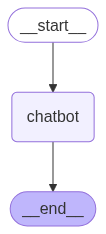

In [6]:
from IPython.display import Image, display

# 可视化展示这个工作流
try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [7]:
from langchain.schema import AIMessage 

def stream_graph_updates(user_input: str):
    # 向 graph 传入一条消息（触发状态更新 add_messages）
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            if "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)

def run():
    # 执行这个工作流
    while True:
        user_input = input("User: ")
        if user_input.strip() == "":
            break
    
        stream_graph_updates(user_input)

In [8]:
run()

Assistant: 你好！我是Qwen，这是我的英文名，你也可以叫我通义千问。我是阿里云自主研发的超大规模语言模型，能够帮助人们回答问题、创作文字，还能表达观点、撰写代码等。有什么我可以帮助你的吗？
Assistant: 你好，Eric！很高兴认识你。有什么我可以帮助你的吗？
Assistant: 您好！您是使用这个平台的用户。不过，您的问题似乎是在寻找更个人化的答案。如果您是在寻找关于您自己的信息，那么可能需要提供更多的上下文或细节，比如您想了解的是哪个方面的身份（例如：在某个社群中的角色、在某项活动中的参与者等）。如果这是一个哲学性的问题，那它探讨的就是自我认知和身份的主题了。请问您具体是指哪一方面呢？这样我或许能更好地帮助到您。


## 3. 实现RAG

In [ ]:
# !pip install -U langchain-community pymupdf
# !pip install dashscope
# !pip install faiss-cpu

In [9]:
from langchain_community.embeddings import DashScopeEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# 加载文档
loader = PyMuPDFLoader("./data/deepseek-v3-1-4.pdf")
pages = loader.load_and_split()

# 文档切分
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=200,
    length_function=len,
    add_start_index=True,
)

texts = text_splitter.create_documents(
    [page.page_content for page in pages[:2]]
)

# 灌库
embeddings = DashScopeEmbeddings(model="text-embedding-v1")
db = FAISS.from_documents(texts, embeddings)

# 检索 top-5 结果
retriever = db.as_retriever(search_kwargs={"k": 5})

In [10]:
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

# Prompt模板
template = """请根据对话历史和下面提供的信息回答上面用户提出的问题:
{query}
"""
prompt = ChatPromptTemplate.from_messages(
    [
        HumanMessagePromptTemplate.from_template(template),
    ]
)

In [11]:
def retrieval(state: State):
    user_query = ""
    if len(state["messages"]) >= 1:
        # 获取最后一轮用户输入
        user_query = state["messages"][-1]
    else:
        return {"messages": []}
    # 检索
    docs = retriever.invoke(str(user_query))
    # 填 prompt 模板
    messages = prompt.invoke("\n".join([doc.page_content for doc in docs])).messages
    return {"messages": messages}

In [12]:
graph_builder = StateGraph(State)
graph_builder.add_node("retrieval", retrieval)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "retrieval")
graph_builder.add_edge("retrieval","chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

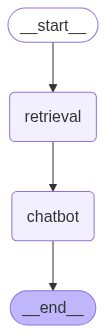

In [13]:
from IPython.display import Image, display

# 可视化展示这个工作流
try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [14]:
run()

Assistant: DeepSeek-V3 是一个大型的混合专家（Mixture-of-Experts, MoE）模型，总共有 671 亿参数，但每次处理一个 token 时仅激活其中的 37 亿参数。这种设计旨在提高推理效率和降低训练成本，同时保持强大的性能。


## 4. 加入分支：若找不到答案则转人工处理

In [15]:
from langchain.schema import HumanMessage
from typing import Literal
from langgraph.types import interrupt, Command

# 校验
def verify(state: State)-> Literal["chatbot","ask_human"]:
    message = HumanMessage("请根据对话历史和上面提供的信息判断，已知的信息是否能够回答用户的问题。直接输出你的判断'Y'或'N'")
    ret = llm.invoke(state["messages"]+[message])
    if 'Y' in ret.content:
        return "chatbot"
    else:
        return "ask_human"

# 人工处理
def ask_human(state: State):
    user_query = state["messages"][-2].content
    human_response = interrupt(
       {
          "question": user_query
       }
    )
    # Update the state with the human's input or route the graph based on the input.
    return {
        "messages": [AIMessage(human_response)]
    }

In [16]:
from langgraph.checkpoint.memory import MemorySaver

# 用于持久化存储 state (这里以内存模拟）
# 生产中可以使用 Redis 等高性能缓存中间件
memory = MemorySaver()

graph_builder = StateGraph(State)

graph_builder.add_node("retrieval", retrieval)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("ask_human", ask_human)

graph_builder.add_edge(START, "retrieval")
graph_builder.add_conditional_edges("retrieval", verify)
graph_builder.add_edge("ask_human", END)
graph_builder.add_edge("chatbot", END)

# 中途会被转人工打断，所以需要 checkpointer 存储状态
graph = graph_builder.compile(checkpointer=memory)

In [18]:
from langchain.schema import AIMessage 

# 当使用 checkpointer 时，需要配置读取 state 的 thread_id
# 可以类比 OpenAI Assistants API 理解，或者想象 Redis 中的 key 
thread_config = {"configurable": {"thread_id": "123456"}}

def stream_graph_updates(user_input: str):
    # 向 graph 传入一条消息（触发状态更新 add_messages）
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        thread_config
    ):
        for value in event.values():
            if isinstance(value, tuple):
                return value[0].value["question"]
            elif "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)
                return None
    return None

def resume_graph_updates(human_input: str):
    for event in graph.stream(
        Command(resume=human_input), thread_config, stream_mode="updates"
    ):
        for value in event.values():
            if "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)
def run():
    # 执行这个工作流
    while True:
        user_input = input("User: ")
        if user_input.strip() == "":
            break
        question = stream_graph_updates(user_input)
        if question:
            human_answer = input("Ask Human: "+question+"\nHuman: ")
            resume_graph_updates(human_answer)

In [22]:
run()

Assistant: DeepSeek-V3 模型的总参数量为 671 亿（671B）个参数，其中每个 token 激活 37 亿（37B）个参数。
Assistant: deepseek R1未提及有多少参数


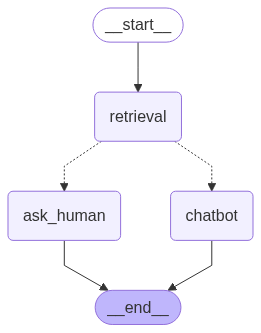

In [20]:
from IPython.display import Image, display

# 可视化展示这个工作流
try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

LangGraph 还支持：

- 工具调用
- 并行处理
- 状态持久化
- 对话历史管理
- 历史动作回放（用于调试与测试）
- 子图管理
- 多智能体协作
- ...
  
更多关于 LangGraph 的 HowTo，参考官方文档：https://langchain-ai.github.io/langgraph/how-tos